# Actividad 2 - Alex Herrerías Ramírez

A lo largo de la practica, como objetivo principal desarrollaremos los siguientes objetivos: 

1. Construir modelos con **3 y 4 capas ocultas**, cada una de ellas con 100 y 300 neuronas por capa usando un LR fijo.
3. Tomar las mejores configuraciones de 3 y 4 capas y **ajustar el Learning Rate** para comparar resultados.
4. Una vez que tengamos un LR seleccionado y el numero de capas ocultas optimo, haremos pruebas para obtener el mejor numero de neuronas.
5. Seleccionar el mejor modelo con todos los parametros testeados

Antes de empezar, nos aseguramos de tener las librerias instaladas necesarias

In [6]:
pip install tensorflow

Note: you may need to restart the kernel to use updated packages.


Cargamos todas las librerias necesarias para el desarrollo del ejercicio y fijamos una seed para poder reproducir los resultados

In [1]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import numpy as np
import os

tf.random.set_seed(42)
np.random.seed(42)

## 1. Carga y Preprocesamiento de Datos
Cargamos el dataset y dividimos los datos de entrenamiento para crear un conjunto de validación y escalamos los valores de los píxeles al rango [0, 1] como en el GitHub.

In [2]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.mnist.load_data()

X_valid, X_train = X_train_full[:5000] / 255.0, X_train_full[5000:] / 255.0
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]
X_test = X_test / 255.0

print("Conjunto de entrenamiento:", X_train.shape)
print("Conjunto de validación:", X_valid.shape)
print("Conjunto de test:", X_test.shape)

Conjunto de entrenamiento: (55000, 28, 28)
Conjunto de validación: (5000, 28, 28)
Conjunto de test: (10000, 28, 28)


## 2. Definición de la Función del Modelo

Una vez que tenemos los datos necesarios para entrenar el modelo, debido a que durante el resto de la practica vamos a entrenar el mismo modelo cambiando parametros, he implementado una función  llamada entrenar_modelo que nos permite modificar de forma sencilla la arquitectura de la red, pero cambiando los parametros y asi evitamos el codigo redundante, en concreto podemos ajustar:

El número de capas ocultas (capas).

Las neuronas que tendrá cada una de esas capas (neuronas).

La tasa de aprendizaje del modelo (lr).

Como indica el ejercicio y el GitHub de referencia usaremos SGD como optimizador y Sparse Categorical Crossentropy como función de pérdida.

In [3]:
def entrenar_modelo(capas=3, neuronas=100, lr=0.01):
    modelo = keras.models.Sequential()
    modelo.add(keras.layers.Flatten(input_shape=[28, 28]))
    
    # añadir capas ocultas 
    for _ in range(capas):
        modelo.add(keras.layers.Dense(neuronas, activation="relu"))
        
    # capa de salida fija
    modelo.add(keras.layers.Dense(10, activation="softmax"))
    
    # optimizador recomendado por la practica
    optimizer = keras.optimizers.SGD(learning_rate=lr)
    modelo.compile(loss="sparse_categorical_crossentropy",
                  optimizer=optimizer,
                  metrics=["accuracy"])
    return modelo

Iniciamos el early_stopping que usaremos en todos los modelos, los parametros usados han sido seleccionado despues de varias pruebas con los modelos, para asegurarnos de que no ocurre el overfitting y tampoco se para de entrenar antes de tiempo ya que con algunos LR el aprendizaje es irregular

In [4]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=15,mode="min",start_from_epoch=10, restore_best_weights=True)

## 3. Comparación de Arquitecturas (Capas y Neuronas)

## Modelo 1: Arquitectura Base

Como primer modelo usaremos la configuración mas básica que se nos menciona en el enunciado. En concreto, utilizamos:

- Capas ocultas: 3

- Neuronas por capa: 100

- Learning rate: 0.01

Modelo 1 (3 capas, 100 neuronas)
Precisión modelo 1: 0.9750


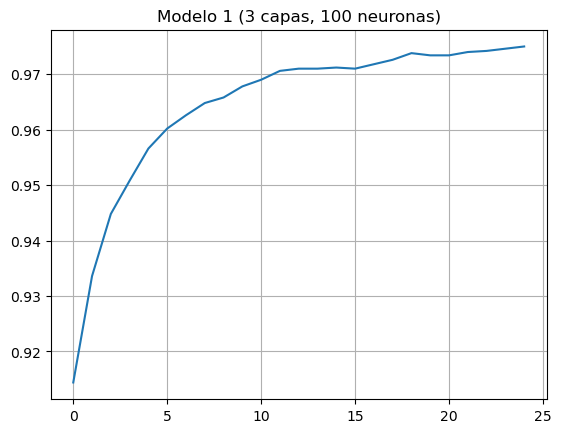

In [9]:
keras.backend.clear_session()

print("Modelo 1 (3 capas, 100 neuronas)")
model_1 = entrenar_modelo(capas=3, neuronas=100, lr=0.01)

history_1 = model_1.fit(X_train, y_train, epochs=50,
                        validation_data=(X_valid, y_valid),
                        callbacks=[early_stopping],
                        verbose=0)

best_acc_1 = max(history_1.history['val_accuracy'])
print(f"Precisión modelo 1: {best_acc_1:.4f}")

plt.plot(history_1.history['val_accuracy'], label='Precisión')
plt.title('Modelo 1 (3 capas, 100 neuronas)')
plt.grid(True)
plt.show()

**Resultados Modelo 1:**

La mejor precisión en validación alcanzada ha sido de 0.9750.

Revisando la curva de aprendizaje podemos observar una convergencia estable y sin oscilaciones relevantes. Tambíen podemos ver que el modelo entra pronto en estancamiento, lo que nos indica que su capacidad de representación es limitada.

## Modelo 2: Aumentando de neuronas por capa

Como segundo modelo mantendremos el mismo numero de capas, pero incrementamos el numero de neuronas:

- Capas ocultas: 3

- Neuronas por capa: 300

- Learning rate: 0.01

Modelo 2 (3 capas, 300 neuronas)
Precisión modelo 2: 0.9808


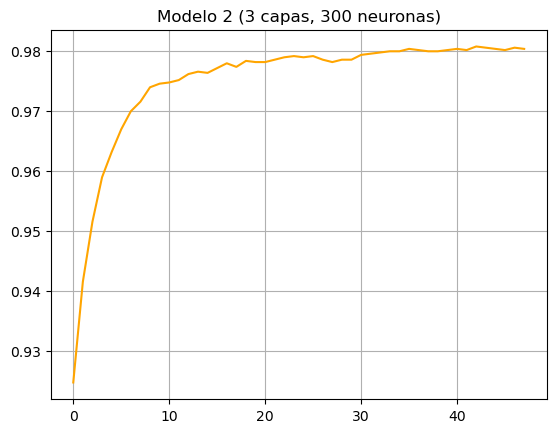

In [10]:
keras.backend.clear_session()

print("Modelo 2 (3 capas, 300 neuronas)")
model_2 = entrenar_modelo(capas=3, neuronas=300, lr=0.01)

history_2 = model_2.fit(X_train, y_train, epochs=50,
                        validation_data=(X_valid, y_valid),
                        callbacks=[early_stopping],
                        verbose=0)

best_acc_2 = max(history_2.history['val_accuracy'])
print(f"Precisión modelo 2: {best_acc_2:.4f}")

plt.plot(history_2.history['val_accuracy'], label='Precisión', color='orange')
plt.title('Modelo 2 (3 capas, 300 neuronas)')
plt.grid(True)
plt.show()

**Resultados modelo 2:**
* La mejor precisión en validación alcanzada ha sido de 0.9808.
* La curva de aprendizaje presenta una pendiente inicial más pronunciada, señal de que el modelo aprende patrones relevantes con mayor rapidez.
* Dado que ha superado el modelo base, de momento podemos asumir que el modelo podría estar limitado por el numero de neuronas

## Modelo 3: Aumentando las capas profundas
Para poder observar si el rendimiento del modelo depende del numero de neuronas o de las capas ocultas, añadiremos una capa oculta extra, en concreto:
- Capas Ocultas: 4
- Neuronas: 100
- Learning Rate: 0.01

Modelo 3 (4 capas, 100 neuronas)
 -> Precisión modelo 3: 0.9746


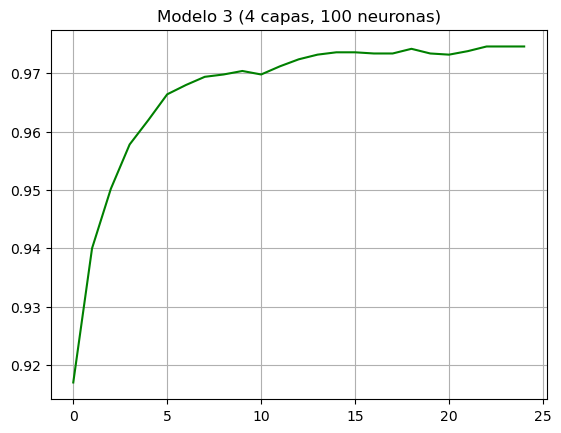

In [11]:
keras.backend.clear_session()

print("Modelo 3 (4 capas, 100 neuronas)")
model_3 = entrenar_modelo(capas=4, neuronas=100, lr=0.01)

history_3 = model_3.fit(X_train, y_train, epochs=50,
                        validation_data=(X_valid, y_valid),
                        callbacks=[early_stopping],
                        verbose=0)

best_acc_3 = max(history_3.history['val_accuracy'])
print(f" -> Precisión modelo 3: {best_acc_3:.4f}")

plt.plot(history_3.history['val_accuracy'], label='Precisión', color='green')
plt.title('Modelo 3 (4 capas, 100 neuronas)')
plt.grid(True)
plt.show()

**Resultados modelo 3:**
* La mejor precisión en validación alcanzada ha sido de 0.9746, ligeramente inferior al del modelo base.
* Este resultado nos puede indicar que aumentar las capas ocultas sin incrementar las neuronas no aporta beneficios y, de hecho, puede dificultar ligeramente la optimización.

## Modelo 4: Aumento de capas y neuronas
Tras los resultados anteriores, combinamos ambas mejoras, en concreto:

- Capas ocultas: 4

- Neuronas por capa: 300

- Learning rate: 0.01

Modelo 4 (4 capas, 300 neuronas)
Precisión modelo 4: 0.9790


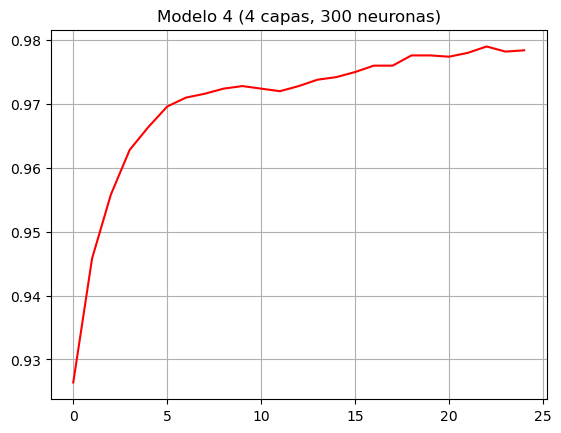

In [13]:
keras.backend.clear_session()

print("Modelo 4 (4 capas, 300 neuronas)")
model_4 = entrenar_modelo(capas=4, neuronas=300, lr=0.01)

history_4 = model_4.fit(X_train, y_train, epochs=50,
                        validation_data=(X_valid, y_valid),
                        callbacks=[early_stopping],
                        verbose=0)

best_acc_4 = max(history_4.history['val_accuracy'])
print(f"Precisión modelo 4: {best_acc_4:.4f}")

plt.plot(history_4.history['val_accuracy'], label='Precisión', color='red')
plt.title('Modelo 4 (4 capas, 300 neuronas)')
plt.grid(True)
plt.show()

**Resultados modelo 4:**
* La mejor precisión en validación alcanzada ha sido de 0.9790.
* Aunque el resultado es alto, es inferior al obtenido por el Modelo 2 (0.9808) y la curva de aprendizaje es mas inestable.

## Ajuste de Learning Rate
Dado que los resultados muestran que el Modelo 2 (3 capas, 300 neuronas) es el que ofrece el mejor rendimiento hasta el momento, tomaremos esta arquitectura como referencia para estudiar el efecto de la tasa de aprendizaje, posteriormente realizaremos el mismo proceso para la mejor arquitectura de 4 capas para observar las diferencias.

El LR base para todos los modelos entrenados era de **0.01**, ahora probaremos:
1.  **LR = 0.05** (Aprendizaje intermedio)
2.  **LR = 0.1** (Aprendizaje agresivo)
3.  **LR = 0.2** (Aprendizaje muy agresivo)

In [14]:
keras.backend.clear_session()

print("(3 capas, 300 neuronas, LR=0.05)")
model_3_005 = entrenar_modelo(capas=3, neuronas=300, lr=0.05)

history_3_005 = model_3_005.fit(X_train, y_train, epochs=50,
                                validation_data=(X_valid, y_valid),
                                callbacks=[early_stopping],
                                verbose=0)

best_acc_3_005 = max(history_3_005.history['val_accuracy'])
print(f"(3 capas, 300 neuronas, LR=0.05): {best_acc_3_005:.4f}")

(3 capas, 300 neuronas, LR=0.05)
(3 capas, 300 neuronas, LR=0.05): 0.9832


In [ ]:
keras.backend.clear_session()

print("(3 capas, 300 neuronas, LR=0.1)")
model_3_01 = entrenar_modelo(capas=3, neuronas=300, lr=0.1)

history_3_01 = model_3_01.fit(X_train, y_train, epochs=50,
                                validation_data=(X_valid, y_valid),
                                callbacks=[early_stopping],
                                verbose=0)

best_acc_3_01 = max(history_3_01.history['val_accuracy'])
print(f"(3 capas, 300 neuronas, LR=0.1): {best_acc_3_01:.4f}")


(3 capas, 300 neuronas, LR=0.1)
(3 capas, 300 neuronas, LR=0.1): 0.9852


In [21]:
keras.backend.clear_session()

print("(3 capas, 300 neuronas, LR=0.2)")
model_3_02 = entrenar_modelo(capas=3, neuronas=300, lr=0.2)

history_3_02 = model_3_02.fit(X_train, y_train, epochs=50,
                                validation_data=(X_valid, y_valid),
                                callbacks=[early_stopping],
                                verbose=0)

best_acc_3_02 = max(history_3_02.history['val_accuracy'])
print(f"(3 capas, 300 neuronas, LR=0.2): {best_acc_3_02:.4f}")

(3 capas, 300 neuronas, LR=0.2)
(3 capas, 300 neuronas, LR=0.2): 0.9844


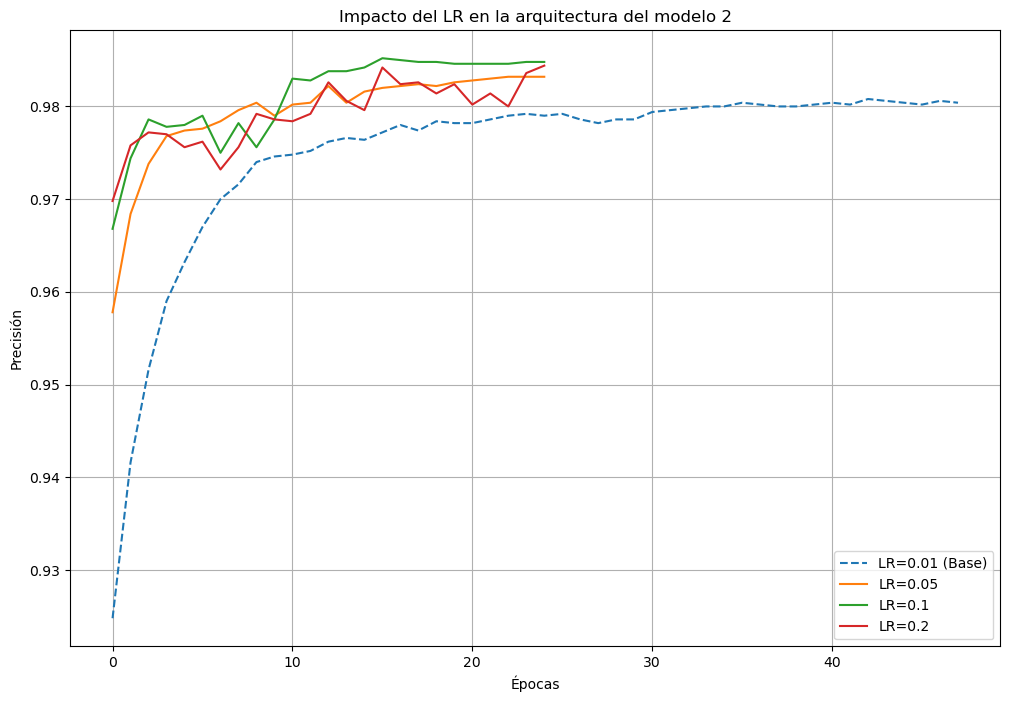

1. LR=0.01:         0.9808
2. LR=0.05:         0.9832
2. LR=0.1:          0.9852
3. LR=0.2:          0.9844


In [22]:
plt.figure(figsize=(12, 8))

# comparación modelo 2 con sus cambios de LR
plt.plot(history_2.history['val_accuracy'], label='LR=0.01 (Base)', linestyle='--')

plt.plot(history_3_005.history['val_accuracy'], label='LR=0.05')
plt.plot(history_3_01.history['val_accuracy'], label='LR=0.1')
plt.plot(history_3_02.history['val_accuracy'], label='LR=0.2')

plt.title("Impacto del LR en la arquitectura del modelo 2")
plt.xlabel("Épocas")
plt.ylabel("Precisión")
plt.legend()
plt.grid(True)
plt.show()

print(f"1. LR=0.01:         {best_acc_2:.4f}")
print(f"2. LR=0.05:         {best_acc_3_005:.4f}")
print(f"2. LR=0.1:          {best_acc_3_01:.4f}")
print(f"3. LR=0.2:          {best_acc_3_02:.4f}")

### Conclusiones
2.  **Impacto del Learning Rate:**
- LR = 0.01: Con la tasa base, el modelo converge de manera estable pero más lenta, alcanzando una precisión de 0.9808.

- LR = 0.05: Incrementar el LR mejora la velocidad de aprendizaje y la precisión final, logrando 0.9832, un avance notable respecto al LR base.

- LR = 0.1: Esta tasa produce la mejor precisión observada: 0.9852, mostrando que un aprendizaje más agresivo puede ser beneficioso sin comprometer la estabilidad.

- LR = 0.2: Un LR demasiado alto provoca inestabilidad y oscilaciones en la curva de validación, reduciendo la precisión a 0.9844, lo que evidencia que valores excesivamente agresivos perjudican el entrenamiento.

## Ajuste de Learning Rate parte 2
Realizamos el mismo proceso para la mejor arquitectura de 4 capas para observar si optimizando el LR podemos superar al modelo 2.

El LR base para todos los modelos entrenados era de **0.01**, ahora probaremos:
1.  **LR = 0.05** (Aprendizaje intermedio)
2.  **LR = 0.1** (Aprendizaje agresivo)
3.  **LR = 0.2** (Aprendizaje muy agresivo)

In [24]:
keras.backend.clear_session()

print("(4 capas, 300 neuronas, LR=0.05)")
model_4_005 = entrenar_modelo(capas=4, neuronas=300, lr=0.05)

history_4_005 = model_4_005.fit(X_train, y_train, epochs=50,
                                validation_data=(X_valid, y_valid),
                                callbacks=[early_stopping],
                                verbose=0)

best_acc_4_005 = max(history_4_005.history['val_accuracy'])
print(f"(4 capas, 300 neuronas, LR=0.05): {best_acc_4_005:.4f}")

(4 capas, 300 neuronas, LR=0.05)
(4 capas, 300 neuronas, LR=0.05): 0.9848


In [25]:
keras.backend.clear_session()

print("(4 capas, 300 neuronas, LR=0.1)")
model_4_01 = entrenar_modelo(capas=4, neuronas=300, lr=0.1)

history_4_01 = model_4_01.fit(X_train, y_train, epochs=50,
                                  validation_data=(X_valid, y_valid),
                                  callbacks=[early_stopping],
                                  verbose=0)

best_acc_4_01 = max(history_4_01.history['val_accuracy'])
print(f"(4 capas, 300 neuronas, LR=0.1): {best_acc_4_01:.4f}")

(4 capas, 300 neuronas, LR=0.1)
(4 capas, 300 neuronas, LR=0.1): 0.9852


In [26]:
keras.backend.clear_session()

print("(4 capas, 300 neuronas, LR=0.2)")
model_4_02 = entrenar_modelo(capas=4, neuronas=300, lr=0.2)

history_4_02 = model_4_02.fit(X_train, y_train, epochs=50,
                                validation_data=(X_valid, y_valid),
                                callbacks=[early_stopping],
                                verbose=0)

best_acc_4_02 = max(history_4_02.history['val_accuracy'])
print(f"(4 capas, 300 neuronas, LR=0.2): {best_acc_4_02:.4f}")

(4 capas, 300 neuronas, LR=0.2)
(4 capas, 300 neuronas, LR=0.2): 0.9848


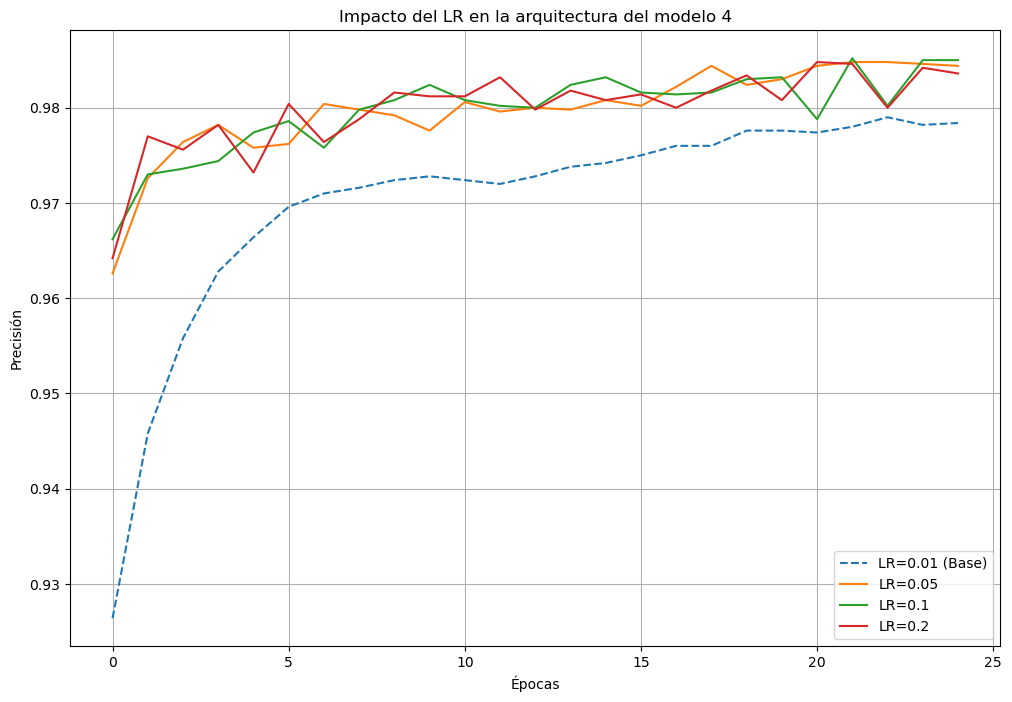

Resumen Final:
1. LR=0.01:         0.9790
2. LR=0.05:         0.9848
2. LR=0.1:          0.9852
3. LR=0.2:          0.9848


In [27]:
plt.figure(figsize=(12, 8))

# comparación modelo 4 con sus cambios de LR
plt.plot(history_4.history['val_accuracy'], label='LR=0.01 (Base)', linestyle='--')

plt.plot(history_4_005.history['val_accuracy'], label='LR=0.05')
plt.plot(history_4_01.history['val_accuracy'], label='LR=0.1')
plt.plot(history_4_02.history['val_accuracy'], label='LR=0.2')

plt.title("Impacto del LR en la arquitectura del modelo 4")
plt.xlabel("Épocas")
plt.ylabel("Precisión")
plt.legend()
plt.grid(True)
plt.show()

print("Resumen Final:")
print(f"1. LR=0.01:         {best_acc_4:.4f}")
print(f"2. LR=0.05:         {best_acc_4_005:.4f}")
print(f"2. LR=0.1:          {best_acc_4_01:.4f}")
print(f"3. LR=0.2:          {best_acc_4_02:.4f}")

### Conclusiones
2.  **Impacto del Learning Rate:**
- LR = 0.01: Con la tasa base, el modelo converge de manera estable, alcanzando una precisión de 0.9806.

- LR = 0.05: El modelo alcanza una precisión máxima de validación de 0.9848. La curva muestra una convergencia estable y sin oscilaciones significativas, indicando un aprendizaje rápido y controlado.

- LR = 0.1: Incrementar el learning rate a 0.1 mejora la precisión final a 0.9852. La curva es un poco más inestable.

- LR = 0.2: Obtiene una precisión de 0.9848. La gráfica evidencia oscilaciones y colapsos de rendimiento tras ciertas épocas, indicando que este LR es excesivo para esta arquitectura como tambien observamos en el modelo de 3 capas.

## 4. Conclusiones de las Comparativas y Selección de Hiperparámetros

Tras realizar las pruebas  tanto en capas como en neuronas y de LR, podemos analizar tanto la precisión final como la estabilidad de las curvas para obtener las siguientes conclusiones:

- Anchura vs. Profundidad: El modelo se beneficia claramente de aumentar las neuronas  más que la cantidad de capas.
 
    - Pasar de 100 a 300 neuronas mejoró el rendimiento en todos los casos.

    - Pasar de 3 a 4 capas  no ofrecio ninguna mejora (0.9852 vs 0.9852), pero a costa de mayor tiempo de ejecución y riesgo de sobreajuste. Por eficiencia, preferimos la arquitectura de 3 capas.

- Tasa de Aprendizaje (LR) y Estabilidad:

    - LR = 0.01 (Base): Demasiado conservador. Convergencia lenta y precisión final inferior.

    - LR = 0.05: Es el valor más estable. Las curvas de aprendizaje son suaves y consistentes, garantizando una convergencia segura, aunque se queda ligeramente por debajo en precisión máxima (0.9832).

    - LR = 0.1 y 0.2: Son más agresivos y alcanzan mayor precisión con problemas de oscilación:

        - el LR 0.1 fue el ganador 0.9852 en ambos modelos.

        - el LR de 0.2 en ambos modelos obtiene un rendimiento parecido a un LR de 0.1, pero con mayor oscilación.

**Modelo elegido final:**

Basado en estos datos, voy a elegir el modelo de 3 capas y LR de 0.1 para seguir optimizando.
Para el paso final usaremos estos dos valores y realizaremos una búsqueda para encontrar el número óptimo de neuronas.

## 5. Búsqueda del Modelo Óptimo (Fine-Tuning de Neuronas con Early Stopping)

A continuación, probaremos distintas configuraciones de neuronas `[50,100,200,250,300,400]` manteniendo fijos:
* **Capas:** 3
* **Learning Rate:** 0.1

Iniciamos las variables necesarias

In [28]:
lista_neuronas = [50,100,200,250,300,400]
lr_optimo = 0.1
capas_fijas = 3

resultados = {}
epochs_log = {}

Probamos todas las neuronas en la misma ejecución para evitar codigo redundante, el funcionamiento es el mismo que en el resto de modelos


 Neuronas: 50
Precisión: 0.9766

 Neuronas: 100
Precisión: 0.9838

 Neuronas: 200
Precisión: 0.9848

 Neuronas: 250
Precisión: 0.9852

 Neuronas: 300
Precisión: 0.9858

 Neuronas: 400
Precisión: 0.9866


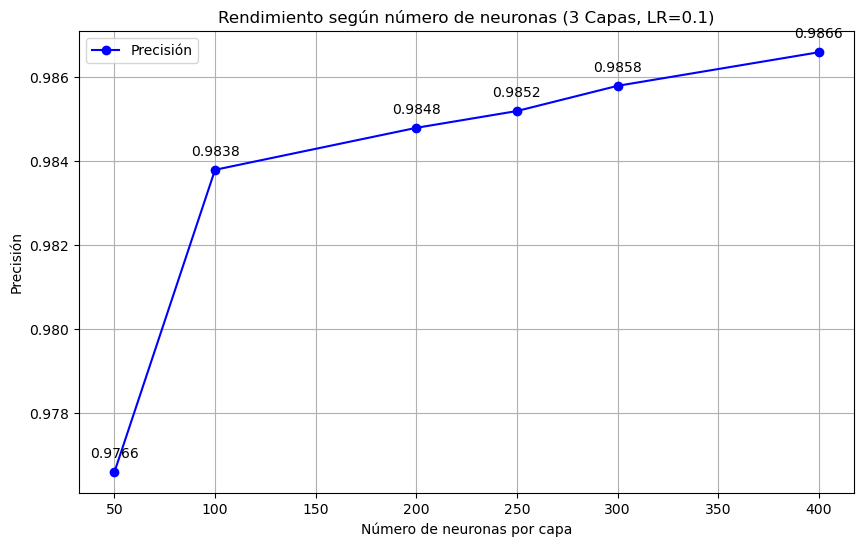

In [30]:
for n in lista_neuronas:
    keras.backend.clear_session()
    print(f"\n Neuronas: {n}")
    model_final = entrenar_modelo(capas=capas_fijas, neuronas=n, lr=lr_optimo)
    
    history = model_final.fit(
        X_train, y_train, 
        epochs=50,
        validation_data=(X_valid, y_valid),
        callbacks=[early_stopping],
        verbose=0
    )
    
    best_acc = max(history.history['val_accuracy'])
    resultados[n] = best_acc
    epochs_log[n] = len(history.epoch)
    print(f"Precisión: {best_acc:.4f}")


# comparación final de modelos
plt.figure(figsize=(10, 6))
plt.plot(list(resultados.keys()), list(resultados.values()), marker='o', linestyle='-', color='b', label='Precisión')

for neurona, acc in resultados.items():
    plt.annotate(f"{acc:.4f}", (neurona, acc), textcoords="offset points", xytext=(0,10), ha='center')

plt.title('Rendimiento según número de neuronas (3 Capas, LR=0.1)')
plt.xlabel('Número de neuronas por capa')
plt.ylabel('Precisión')
plt.grid(True)
plt.legend()
plt.show()

# Conclusiones Finales

Tras realizar todas las pruebas para obtener los mejores parametros posibles, podemos concluir que:

- Configuración Óptima:

    - La arquitectura con 400 neuronas se selecciona como la ganadora.

    - Si se buscara eficiencia computacional, el modelo de 200 neuronas (98.48%) es una buena alternativa, sacrificando un poco más de un 0.1% de precisión por una reducción del 50% en parámetros.

- Modelo Final Seleccionado:

    - Capas Ocultas: 3

    - Neuronas por capa: 400

    - Learning Rate: 0.1

    - Optimizador: SGD

    - Precisión Final en Validación: ~98.66%